In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
# from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/all')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [7]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
workers=7
random_crop=True
pseudo_label=False
val_folder = 'sample_test_sync'
# val_folder = 'val'
S_PREFIX = '47_vgg11'

In [8]:
from torchvision.datasets.folder import pil_loader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TTF

### Create dataloader

In [9]:
class MatchedFilesDataset(Dataset):
    def __init__(self, fnames, y, tfms, path):
        self.path,self.fnames = path,fnames
        self.open_fn = pil_loader
        self.y=y
        self.open_y_fn = pil_loader
        assert(len(fnames)==len(y))
        
        self.n = self.get_n()
        self.c = self.get_c()
        self.tfms = tfms
        
    def get_x(self, i): return self.open_fn(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): return self.open_y_fn(os.path.join(self.path, self.y[i]))
    def get_n(self): return len(self.fnames)
    def get_c(self): return 2
    
    def get(self, tfms, x, y):
        for fn in tfms:
            #pdb.set_trace()
            x, y = fn(x, y)
        return (x, y)
    
    def __getitem__(self, idx):
        x,y = self.get_x(idx),self.get_y(idx)
        return self.get(self.tfms, x, y)
    
    def __len__(self): return self.n

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

In [10]:

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [11]:
def crop_bg_pil(x,y):
    w, h = x.size
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    pad_right=32-w%32
    if pad_right == 32: pad_right = 0
    return TTF.crop(x, top, 0, bot-top, w+pad_right), TTF.crop(y, top, 0, bot-top, w+pad_right)

In [12]:
class RHF(object):
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x, y):
        if random.random() < self.p:
            return TTF.hflip(x), TTF.hflip(y)
        return x,y

In [13]:
class RR(object):
    def __init__(self, degrees=2): self.degrees = degrees
    def __call__(self, x, y):
        angle = random.uniform(-self.degrees, self.degrees)
        return TTF.rotate(x, angle), TTF.rotate(y, angle)

In [14]:
def tfm_x_wrapper(tfm):
    return lambda x,y: (tfm(x), y)

In [15]:
class RC():
    def __init__(self, targ_sz):
        self.targ_sz = targ_sz

    def __call__(self, x, y):
        rand_w = random.uniform(0, 1)
        rand_h = random.uniform(0, 1)
        w,h = x.size
        t_w,t_h = self.targ_sz
        start_x = np.floor(rand_w*(w-t_w)).astype(int)
        start_y = np.floor(rand_h*(h-t_h)).astype(int)
        return TTF.crop(x, start_y, start_x, t_h, t_w), TTF.crop(y, start_y, start_x, t_h, t_w)

In [16]:
def convert_y_ce(y_img):
    y_new = np.zeros(y_img.shape, dtype=int)
    y_new[y_img==VEHICLES] = 1
    cutoff_y = int(y_new.shape[0]*.875)
    y_new[cutoff_y:,:] = 0

    y_new[y_img==ROADS] = 2
    y_new[y_img==ROAD_LINES] = 2
    return torch.from_numpy(y_new).long()

In [17]:
def convert_y(y_img):
    yr = (y_img==ROADS) | (y_img==ROAD_LINES)
    yc = (y_img==VEHICLES)
    cutoff_y = int(yc.shape[0]*.875)
    yc[cutoff_y:,:] = 0
    rn = ~(yr | yc)
    return torch.from_numpy(np.stack((rn,yc,yr)).astype(int))


def xy_tensor(x,y):
    y_img = np.array(y, np.int32, copy=False)
    return TTF.to_tensor(x), convert_y_ce(y_img[:,:,0])

In [18]:
class RRC(transforms.RandomResizedCrop):
    def __call__(self, x, y):
        i, j, h, w = self.get_params(x, self.scale, self.ratio)
        x = TTF.resized_crop(x, i, j, h, w, self.size, self.interpolation)
        y = TTF.resized_crop(y, i, j, h, w, self.size, self.interpolation)
        return x, y

In [19]:
def torch_loader(f_ext, data_path, bs, size, workers=7, random_crop=False, pseudo_label=False, val_folder=None, val_bs=None):
    # Data loading code
    x_names = np.sort(np.array(glob(str(data_path/f'CameraRGB{f_ext}'/'*.png'))))
    y_names = np.sort(np.array(glob(str(data_path/f'CameraSeg{f_ext}'/'*.png'))))

    x_n = x_names.shape[0]
    val_idxs = list(range(x_n-300, x_n))
    
    if pseudo_label:
        x_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraRGB{f_ext}/*.png')))
        y_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraSeg{f_ext}/*.png')))
        x_names = np.concatenate((x_names, x_names_test))
        x_names = np.concatenate((y_names, y_names_test))
        print(f'Pseudo-Labels: {len(x_names_test)}')
    if val_folder:
        x_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraRGB{f_ext}/*.png')))
        y_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraSeg{f_ext}/*.png')))
        val_x,val_y = x_names_val, y_names_val
        trn_x,trn_y = x_names, y_names
        print(f'Val Labels:', len(val_x))
    else:
        ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    print(f'Val x:{len(val_x)}, y:{len(val_y)}')
    print(f'Trn x:{len(trn_x)}, y:{len(trn_y)}')
    print(f'All x:{len(x_names)}')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    train_tfms = [
        crop_bg_pil,
        tfm_x_wrapper(transforms.ColorJitter(.2,.2,.2)),
#         tfm_x_wrapper(Lighting(0.1, __imagenet_pca['eigval'], __imagenet_pca['eigvec'])),
        RR(),
        RHF(),
#         RC((size,size)),
        xy_tensor,
        tfm_x_wrapper(normalize),
    ]
    if random_crop:
        train_tfms.insert(3,RRC(size, scale=(0.4, 1.0)))
    train_dataset = MatchedFilesDataset(trn_x, trn_y, train_tfms, path='')
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_tfms = [
        crop_bg_pil,
        xy_tensor,
        tfm_x_wrapper(normalize)
    ]
    val_dataset = MatchedFilesDataset(val_x, val_y, val_tfms, path='')
    if val_bs is None: val_bs = bs
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=val_bs, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data


In [20]:
def denorm(x):
    x_np = x.cpu().numpy()
    x_np = np.rollaxis(x_np, 0, 3)
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    x_np = x_np*std+mean
    return x_np

## U-net (ish)

In [21]:
from torchvision.models import vgg11_bn

In [22]:
def vgg11(pre): return children(vgg11_bn(pre))[0]

In [23]:
model_meta = {
    resnet18:[8,6], resnet34:[8,6], resnet50:[8,6], resnet101:[8,6], resnet152:[8,6],
    vgg11:[0,13], vgg16:[0,22], vgg19:[0,22],
    resnext50:[8,6], resnext101:[8,6], resnext101_64:[8,6],
    wrn:[8,6], inceptionresnet_2:[-2,9], inception_4:[-1,9],
    dn121:[0,7], dn161:[0,7], dn169:[0,7], dn201:[0,7],
}

In [24]:
def get_base(f):
    cut,lr_cut = model_meta[f]
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers), lr_cut

In [25]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [26]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [27]:
class Unet11Mini(nn.Module):
    def __init__(self, out=3, f=vgg11):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base[0]
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,6,13,20,27]]
        self.up0 = UnetBlock(512,512,256)
        self.up1 = UnetBlock(256,512,256)
        self.up2 = UnetBlock(256,256,256)
        self.up3 = UnetBlock(256,128,128)
        self.up4 = UnetBlock(128,64,64)
        self.up5  = nn.Conv2d(64,out,1)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up0(x, self.sfs[4].features)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x

In [28]:
class Unet34Mod(nn.Module):
    def __init__(self, out=3, f=resnet34):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,128)
        self.up4 = UnetBlock(128,64,64)
        self.up5 = UnetBlock(64,32,32)
        self.up6 = nn.ConvTranspose2d(32, out, 1)
        self.x_skip = nn.Sequential(
            nn.Conv2d(out,32,1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
    def forward(self,x):
        x_skip = self.x_skip(x)
        x = self.rn(x)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, x_skip)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [29]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        if isinstance(self.model, FP16):
            model = self.model.module
        else:
            model = self.model
        lgs = list(split_by_idxs(children(model.rn), [model.lr_cut]))
        return lgs + [children(model)[1:]]

In [30]:
def carce_f_p_r(pred, targs):
    _,idx = torch.max(pred, 1)
    return fbeta_score(idx==1, targs[:,:,:]==1, beta=2)

In [31]:
def rdce_f(pred, targs):
    _,idx = torch.max(pred, 1)
    f,p,r = fbeta_score(idx==2, targs[:,:,:]==2, beta=0.5)
    return f

In [32]:
def carsig_f_p_r(pred, targs):
    p2 = F.sigmoid(pred)
    return fbeta_score(p2[:,0,:,:], targs[:,0,:,:], beta=2, threshold=0.5)

In [33]:
def rdsig_f(pred, targs):
    p2 = F.sigmoid(pred)
    f,p,r = fbeta_score(p2[:,1,:,:], targs[:,1,:,:], beta=0.5, threshold=0.5)
    return f

In [34]:
def car_f_p_r(pred, targs):
    _,idx = torch.max(pred, 1)
    return fbeta_score(idx==1, targs[:,1,:,:], beta=2)

In [35]:
def rd_f(pred, targs):
    _,idx = torch.max(pred, 1)
    f,p,r = fbeta_score(idx==2, targs[:,2,:,:], beta=0.5)
    return f

In [36]:
def fbeta_score(y_pred, y_true, beta, threshold=None, eps=1e-9):
    beta2 = beta**2

    if threshold:
        y_pred = torch.ge(y_pred.float(), threshold).float()
    else:
        y_pred = y_pred.float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum()
    precision = true_positive/(y_pred.sum()+(eps))
    recall = true_positive/(y_true.sum()+eps)
    
    fb = (precision*recall)/(precision*beta2 + recall + eps)*(1+beta2)
    
    return fb, precision, recall

In [37]:
def new_acc_sig(pred, targs):
    p2 = F.sigmoid(pred)
    return ((p2>0.5).long() == targs).float().mean()

In [38]:
def new_acc_ce(preds, targs):
    mx,idx = torch.max(preds, 1)
    return (idx == targs).float().mean()

In [39]:
def new_acc(pred, targs):
    _,idx = torch.max(pred, 1)
    _,t_idx = torch.max(targs,1)
    return (idx == t_idx).float().mean()

In [40]:
def dice_coeff_weight(pred, target, weight):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2)
    w = V(weight.view(1,-1,1))
    i_w = (w*intersection).sum()
    m1_w = (w*m1).sum()
    m2_w = (w*m2).sum()
    return (2. * i_w + smooth) / (m1_w + m2_w + smooth)

def dice_coeff(pred, target):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)


class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, softmax=True):
        super(SoftDiceLoss, self).__init__()
        self.weight = weight
        self.softmax = softmax

    def forward(self, logits, targets):
        probs = F.softmax(logits) if self.softmax else F.sigmoid(logits)
        num = targets.size(0)  # Number of batches
        targets = torch.cat(((targets==0).unsqueeze(1), (targets==1).unsqueeze(1), (targets==2).unsqueeze(1)), dim=1).float()
        if isinstance(logits.data, torch.cuda.HalfTensor):
            targets = targets.half()
        else:
            targets = targets.float()
        if self.weight is not None:
            score = dice_coeff_weight(probs, targets, self.weight)
        else:
            score = dice_coeff(probs, targets)
        score = 1 - score.sum() / num
        return score

In [41]:
def get_learner(md, m_fn=Unet11Mini, weights=[1,200,2], half=False, softmax=True, dice=False):
    out_sz = 3 if softmax else 2
    m = to_gpu(m_fn(out_sz))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    class_weights = torch.cuda.FloatTensor(weights)
    if half:
        class_weights = class_weights.half()
        learn.half()
        
    if dice: learn.crit=SoftDiceLoss(weight=class_weights, softmax=softmax)
    else: learn.crit=nn.CrossEntropyLoss(weight=class_weights)
    
    if softmax: learn.metrics = [new_acc_ce, rdce_f, carce_f_p_r]
    else: learn.metrics = [new_acc_sig, rdsig_f, carsig_f_p_r]
    # learn.metrics=[new_acc, rd_f, car_f_p_r]
    
    return learn

### Models

In [102]:
ext = '-300'
sz=192
bs=64
random_crop=True
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [103]:
m = Unet11Mini()

In [104]:
m.rn[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [105]:
learn = get_learner(md, weights=[1,6,2], softmax=True)
# learn.load(f'256urn-40-unet11-mini-softmax-tmp')

 88%|████████▊ | 149/170 [00:26<00:03,  5.61it/s, loss=2.24] 

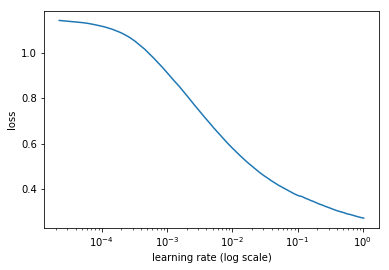

In [106]:
learn.lr_find()
learn.sched.plot()

In [111]:
lr=5e-2
wd=1e-7

lrs = np.array([lr/80,lr/10,lr])/2

In [108]:
learn.freeze_to(1)

In [109]:
learn.fit(lr, 1, wds=wd, cycle_len=30,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.096004   0.09335    0.979139   0.977114   0.821443   0.720103   0.855077  
    1      0.075364   0.090361   0.972371   0.980085   0.780143   0.497367   0.912888  
    2      0.066693   0.064372   0.984737   0.988135   0.870611   0.695097   0.930991  
    3      0.066896   0.071211   0.986959   0.989522   0.856028   0.82587    0.864591  
    4      0.062642   0.076503   0.984923   0.987302   0.85122    0.778274   0.872944  
    5      0.061202   0.064056   0.985788   0.990056   0.880026   0.734558   0.928957  
    6      0.060444   0.06841    0.986415   0.987958   0.855935   0.774511   0.880055  
    7      0.061943   0.071132   0.984703   0.982268   0.858668   0.775061   0.884359  
    8      0.059203   0.085391   0.984592   0.986871   0.846794   0.784408   0.865046  
    9      0.059143   0.082025   0.982779   0.984583   0.820771   0.69029    0.862911  
    10     0.063815   0.077606   0.986095   0.986155

[0.04764939561486244,
 0.9896846842765809,
 0.9912151885032654,
 0.894555253982544,
 0.7996777153015137,
 0.9223898887634278]

In [112]:
learn.save(f'300urn-{S_PREFIX}-tmp')

In [113]:
learn.unfreeze()
learn.set_bn_freeze(learn.model.rn, True)

In [114]:
learn.fit(lrs/40, 1, wds=wd, cycle_len=20,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.04833    0.05015    0.989503   0.990312   0.896537   0.809499   0.921836  
    1      0.047755   0.049072   0.989659   0.990996   0.897432   0.806178   0.924125  
    2      0.04757    0.049234   0.9898     0.990974   0.897299   0.812862   0.92172   
    3      0.046933   0.048602   0.989708   0.991061   0.898414   0.804579   0.925933  
    4      0.046733   0.048302   0.989836   0.991447   0.899279   0.806277   0.926528  
    5      0.046848   0.048525   0.990005   0.991278   0.896513   0.814408   0.920149  
    6      0.046277   0.047439   0.990036   0.991843   0.900479   0.809366   0.927061  
    7      0.046933   0.048338   0.990072   0.991972   0.89899    0.810152   0.924789  
    8      0.045886   0.048173   0.990279   0.992012   0.898499   0.817751   0.921662  
    9      0.045959   0.047799   0.990221   0.991888   0.899047   0.813274   0.9238    
    10     0.045692   0.047948   0.990278   0.992121

[0.047320610880851745,
 0.9903688097000122,
 0.9920884895324708,
 0.9010760736465454,
 0.8160830712318421,
 0.925570170879364]

In [115]:
learn.save(f'300urn-{S_PREFIX}-rc')

In [116]:
ext = '-300'
sz=192
bs=64
random_crop=False
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [117]:
lr=1e-3
wd=1e-7

lrs = np.array([lr/50,lr/10,lr])

In [118]:
learn.load(f'300urn-{S_PREFIX}-rc')

In [119]:
learn.unfreeze()
# learn.set_bn_freeze(learn.model.rn, True)

In [120]:
learn.fit(lrs/80, 1, wds=wd, cycle_len=20,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.045858   0.046527   0.990386   0.992144   0.901871   0.813814   0.927358  
    1      0.045499   0.046361   0.990473   0.99211    0.902229   0.816338   0.926993  
    2      0.045118   0.047045   0.990377   0.992038   0.900561   0.816371   0.924795  
    3      0.045238   0.046694   0.990396   0.99198    0.901187   0.815488   0.925904  
    4      0.045646   0.047081   0.990326   0.991958   0.90168    0.814773   0.92679   
    5      0.044952   0.046781   0.990453   0.992111   0.901229   0.817462   0.925312  
    6      0.045121   0.046563   0.990398   0.991888   0.9015     0.816576   0.925964  
    7      0.0455     0.046766   0.990465   0.992198   0.901367   0.817685   0.925417  
    8      0.045455   0.046295   0.990411   0.991635   0.901115   0.818094   0.924944  
    9      0.045424   0.047416   0.99042    0.992117   0.900005   0.818635   0.923337  
    10     0.046234   0.046389   0.990484   0.992043

[0.04641000270843506,
 0.9904410409927368,
 0.9920058917999267,
 0.9017435503005982,
 0.8158935332298278,
 0.9265050435066223]

In [121]:
learn.save(f'300urn-{S_PREFIX}-nocrop')

In [ ]:
# learn = get_learner(md, weights=[1,6,1], softmax=True, dice=True)
# learn.load(f'300urn-{S_PREFIX}-rc')

# learn.fit(lrs/60, 1, wds=wd, cycle_len=10,use_clr=(20,2))

### 512

In [122]:
ext = ''
sz=320
bs=32
random_crop=True
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [123]:
learn = get_learner(md, weights=[1,6,1], softmax=True, dice=False)
learn.load(f'300urn-{S_PREFIX}-rc')

In [124]:
lr=1e-2
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])/2

In [125]:
learn.unfreeze()
learn.set_bn_freeze(learn.model.rn, True)

In [126]:
learn.fit(lrs, 1, wds=wd, cycle_len=8,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.049726   0.144055   0.966211   0.959904   0.806588   0.660844   0.864498  
    1      0.048467   0.114893   0.971116   0.969913   0.806269   0.615117   0.888197  
    2      0.04632    0.111767   0.975526   0.969559   0.81942    0.668846   0.878311  
    3      0.045766   0.105717   0.977156   0.974863   0.812394   0.642744   0.881221  
    4      0.044151   0.091566   0.979561   0.981112   0.823166   0.639713   0.898401  
    5      0.043795   0.095885   0.979168   0.984012   0.81795    0.635544   0.893858  
    6      0.041897   0.103706   0.980399   0.979461   0.813368   0.657094   0.87523   
    7      0.042073   0.096937   0.980472   0.981958   0.818796   0.64372    0.890015  


[0.09693678081035614,
 0.9804724264144897,
 0.9819580626487732,
 0.8187955474853515,
 0.643720309138298,
 0.8900147128105164]

In [127]:
learn.save(f'600urn-{S_PREFIX}-320')

In [42]:
ext = ''
sz=384
bs=24
random_crop=True
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [43]:
learn = get_learner(md, weights=[1,6,1], softmax=True, dice=False)
learn.load(f'600urn-{S_PREFIX}-320')

In [44]:
lr=1e-3
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [45]:
learn.unfreeze()
learn.set_bn_freeze(learn.model.rn, True)

In [46]:
learn.fit(lrs, 1, wds=wd, cycle_len=8,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.037408   0.074222   0.984106   0.983053   0.863756   0.748513   0.902073  
    1      0.036542   0.073611   0.983616   0.982054   0.865665   0.749924   0.903642  
    2      0.035858   0.068502   0.985372   0.983713   0.869941   0.767936   0.902185  
    3      0.033802   0.069879   0.98465    0.98125    0.872788   0.765963   0.906763  
    4      0.034993   0.068896   0.984855   0.980792   0.873563   0.762292   0.909306  
    5      0.033734   0.066109   0.985731   0.984279   0.873255   0.761452   0.908966  
    6      0.034588   0.063372   0.984958   0.984088   0.867123   0.717302   0.919528  
    7      0.033411   0.06407    0.985889   0.984713   0.873135   0.754782   0.911627  



[0.06406990803778172,
 0.9858893942832947,
 0.9847134971618652,
 0.8731347668170929,
 0.7547824084758759,
 0.9116272282600403]

In [47]:
learn.save(f'600urn-{S_PREFIX}-384')

### Nocrop

In [43]:
ext = ''
sz=384
bs=10
random_crop=False
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=10)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [44]:
learn = get_learner(md, weights=[1,6,1], softmax=True)
learn.load(f'600urn-{S_PREFIX}-384')

In [45]:
lr=1e-3
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])/2

In [46]:
learn.unfreeze()
# learn.bn_freeze(True)
learn.set_bn_freeze(learn.model.rn, True)

In [47]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [48]:
learn.fit(lrs, 1, wds=wd, cycle_len=8,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.019354   0.05315    0.987901   0.988664   0.865779   0.755049   0.901924  
    1      0.015589   0.050898   0.987545   0.989378   0.865618   0.740412   0.908001  
    2      0.015276   0.050835   0.988384   0.988834   0.868634   0.767228   0.902089  
    3      0.015398   0.05059    0.988026   0.989936   0.868582   0.782364   0.898059  
    4      0.012434   0.050843   0.988196   0.989178   0.873788   0.774273   0.906412  
    5      0.012499   0.048416   0.98887    0.989265   0.877941   0.785928   0.907503  
    6      0.011603   0.049167   0.989436   0.990114   0.877475   0.809242   0.899455  
    7      0.011888   0.047989   0.989149   0.989973   0.879205   0.789414   0.908457  



[0.047988875657320025,
 0.9891493153572083,
 0.9899731516838074,
 0.8792047075927257,
 0.789413645863533,
 0.9084567312896251]

In [49]:
learn.save(f'600urn-{S_PREFIX}-384-nocrop')

In [ ]:
learn.fit(lrs/50, 1, wds=wd, cycle_len=6,use_clr=(20,2))

In [ ]:
learn.save(f'600urn-{S_PREFIX}-384-nocrop')

### Change Weights

In [ ]:
ext = ''
sz=384
bs=10
random_crop=False
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=10)

In [ ]:
learn = get_learner(md, m_fn=Unet34Mod, weights=[1,7,1], softmax=True)
learn.load(f'600urn-{S_PREFIX}-384-nocrop')

In [ ]:
lr=1e-4
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [ ]:
learn.unfreeze()
# learn.bn_freeze(True)
learn.set_bn_freeze(learn.model.rn, True)

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=6,use_clr=(20,2))

In [ ]:
learn.save(f'600urn-{S_PREFIX}-384-nocrop-w8')

In [ ]:
learn.load(f'600urn-{S_PREFIX}-384-nocrop-w8')

In [ ]:
learn.unfreeze()
# learn.bn_freeze(True)
learn.set_bn_freeze(learn.model.rn, True)

In [ ]:
learn.fit(lrs/40, 1, wds=wd, cycle_len=3,use_clr=(20,2))

In [ ]:
learn.save(f'600urn-{S_PREFIX}-384-nocrop-w8-tmp')